# Stock Predictor Project: Up or Down? 
## Stock: NVDA
Info available: 
- Open
- Close 
- High
- Low
- Volume

## What tools am I using?
1. yfinance: for data
2. NumPy: Data manipulation
3. Pandas: Data framework
4. Matplotlib: to plot data
5. sklearn: ML library
   1. LogisticRegression
   2. train_test_split
   3. accuracy_score
   4. confusion_matrix
   5. StandardScaler


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 20)

# # Test yfinance by downloading NVDA data
# nvda = yf.download("NVDA", period="5y")
# print(nvda.head())

# # Simple plot to verify matplotlib
# nvda['Close'].plot(figsize=(10, 5), title='NVIDIA Closing Price')
# plt.xlabel('Date')
# plt.ylabel('Price ($)')
# plt.show()

/var/folders/dl/3vsyz1hx5y34_3mvxbt86q180000gn/T/ipykernel_46311/1431308727.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nvda = yf.download(["NVDA"], period='5y')
[*********************100%***********************]  1 of 1 completed


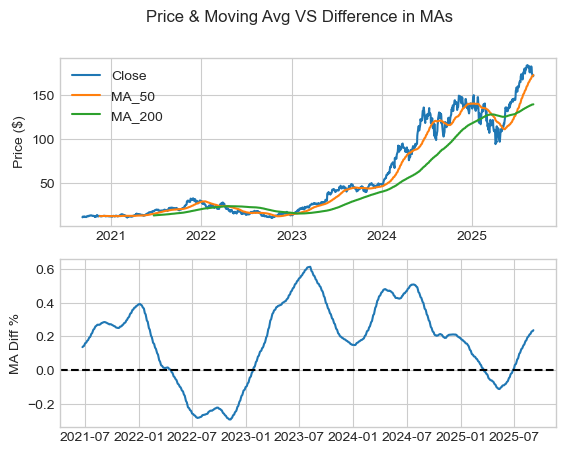

Simple Prediction: 0.5308056872037915
Baseline Prediction, always up: 0.5308056872037915
Proportion of up days: 0.5345971563981042
[[  0  99]
 [  0 112]]
Specificity (True Negative Rate): 0.00
Lowest probability of UP:  0.5939927624793133
Highest probability of UP:  0.8747072838640079
Mean of UP predictions: 0.7393010638991719


In [11]:

# Download NVDA data
nvda = yf.download(["NVDA"], period='5y')

# Flatten MultiIndex columns if needed
if isinstance(nvda.columns, pd.MultiIndex):
    nvda.columns = [col[0] if col[1] == '' else f"{col[0]}_{col[1]}" for col in nvda.columns]

# Reset index to bring 'Date' into columns
nvda = nvda.reset_index()

# Extract Year and Month
nvda['Year'] = nvda['Date'].dt.year
nvda['Month'] = nvda['Date'].dt.month

#now add a daily return part:
nvda['Daily_Return'] = nvda['Close_NVDA'].pct_change()

# the previous days' close
nvda['Prev_Close'] = nvda['Close_NVDA'].shift(1)

# int val (1 / 0) for if price went up or not
nvda['Target'] = (nvda['Close_NVDA'].shift(-1) > nvda['Close_NVDA']).astype(int)

"""
Moving Averages: Avg closing price over a certain peroid of time
-------------------------------------------------------------------
Short-term moving averages crossing above longer-term moving averages is 
generally seen as bullish and short-term moving averages crossing from above
to below long-term moving averages is generally seen as bearish.
"""
nvda['MA_50'] = nvda['Close_NVDA'].rolling(window=50).mean()
nvda['MA_200'] = nvda['Close_NVDA'].rolling(window=200).mean()

nvda['Close_vs_MA_50'] = nvda['Close_NVDA'] - nvda['MA_50']
nvda['Close_vs_MA_200'] = nvda['Close_NVDA'] - nvda['MA_200']

"""
Moving Average difference percentage:
if it >= 0.1 (10%), bullish, strong uptrend
if it <= -0.05 (-5%), bearish, moderate downtrend
if it ~ 0, neutral
"""
nvda['MA_Diff_Pct'] = (nvda['MA_50'] - nvda['MA_200']) / nvda['MA_200']

"""
Plotting The MA Difference Percentage, recall:
- if it >= 0.1 (10%), bullish, strong uptrend
- if it <= -0.05 (-5%), bearish, moderate downtrend
- if it ~ 0, neutral

Also plot the closing price, and both moving averages along with it for
comparison
"""
fig, axs = plt.subplots(2)
fig.suptitle('Price & Moving Avg VS Difference in MAs')
axs[0].plot(nvda['Date'], nvda['Close_NVDA'])
axs[0].plot(nvda['Date'], nvda['MA_50'])
axs[0].plot(nvda['Date'], nvda['MA_200'])
axs[0].legend(["Close", "MA_50", "MA_200"])
axs[0].set_ylabel("Price ($)")

axs[1].plot(nvda['Date'], nvda['MA_Diff_Pct'])
axs[1].set_ylabel("MA Diff %")
axs[1].axhline(0, color="black", linestyle='--')
plt.show()

# drop rows with NaN
nvda = nvda.dropna()


# Now onto training the model.

#Initializing features X and Y:

# Example feature set
features = ['MA_50', 'MA_200', 'MA_Diff_Pct', 'Prev_Close', 'Daily_Return']

X = nvda[features].values   # converts pandas DataFrame -> numpy array
y = nvda['Target'].values   # converts Series -> numpy array

#Now use the train test split library
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# test size = 0.2 means 20% of data goes to testing, and 80% to training
# shuffle false is needed for time series data like stocks

#initialize the logistic regression
logreg = LogisticRegression(class_weight='balanced')

#fit and predict
logreg.fit(X_train, y_train)
y_pred = (logreg.predict_proba(X_test)[:, 1] >= 0.3).astype(int)

#evaluate the predictions
#Simple evaluation, accuracy:
print(f"Simple Prediction: {accuracy_score(y_test, y_pred)}")

#now compare this to baselines: such as always UP or always DOWN
total_up = nvda['Target'].sum()
total_rows = len(nvda)
always_up_acc = total_up / total_rows
#print(always_up_acc)

#now do the actual thing with accuracy score to compare:
y_pred_baseline = np.ones_like(y_test)

baseline_acc = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Prediction, always up: {baseline_acc}")

#The prediction and baseline are the exact same thing.. we may need to rethink Logistic Regression.
#First, lets run some diagnostics to see what our issue is.

#Check the distribution
print(f"Proportion of up days: {y.mean()}")

#Now check with confusion matrix
print(confusion_matrix(y_test, y_pred))

#Check with other metric other than accuracy, using recall first:
specificity = recall_score(y_test, y_pred, pos_label=0)
print(f"Specificity (True Negative Rate): {specificity:.2f}")

#Check the models certainty in guessing UP:
y_proba = logreg.predict_proba(X_test)[:, 1]

print("Lowest probability of UP: ", y_proba.min())
print("Highest probability of UP: ", y_proba.max())
print("Mean of UP predictions:", y_proba.mean())

